# Airbus Ship Detection Challenge
 
**Overview:** 
In this notebook, we build, train, and evaluate deep learning models for ship segmentation on satellite images. We use a combination of data preprocessing, TFRecord pipelines, and several model architectures including:
- **ResUNet** (Residual U-Net)
- **U-Net++** (Nested U-Net)
- **Attention U-Net** (with attention gates)

After training, we implement a **weighted ensemble** of these models using 50% ResUNet, 30% Attention U-Net, and 20% U-Net++, to generate final predictions. This helps leverage the strengths of all models while reducing variance.
 
The challenge is evaluated using the **F2 Score** calculated over multiple Intersection over Union (IoU) thresholds. The final submission requires generating masks in **Run-Length Encoding (RLE)** format.

This notebook is structured as follows:
 
1. Data Loading & Exploration
2. Preprocessing & Augmentation
3. TFRecord Pipeline
4. Model Architectures
    - ResUNet
    - U-Net++
    - Attention U-Net (and a lightweight variant)
5. Training Setup & Callbacks
6. Test-Time Prediction, RLE Submission Generation & Visualizations
7. Results & Highlights

Let's begin!

## 1. Data Loading & Exploration
 
In this section, we load the CSV file containing the segmentation masks (in RLE format), and explore the dataset:
 - How many images contain ships versus no ships
 - Distribution of ship counts per image
 - Sample visualizations of images and their corresponding decoded masks

In [2]:
import os, glob, gc, warnings
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage.io import imread
from skimage.transform import resize
from skimage.measure import label, regionprops

# Enable warnings and garbage collection
warnings.filterwarnings('ignore')
gc.enable()

# Set up TensorFlow and mixed precision for speed
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers, mixed_precision
mixed_precision.set_global_policy('mixed_float16')

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


### Load Data & CSV
 
We load the CSV file and the training image directory. We also add a column `has_ship` to easily filter ship-containing images.

In [4]:
CSV_PATH = "/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv"
TRAIN_DIR = "/kaggle/input/airbus-ship-detection/train_v2"

df = pd.read_csv(CSV_PATH)
df['has_ship'] = df['EncodedPixels'].notnull()

### Data Exploration & Visualization
Let's look at the number of images with ships versus no ships and visualize some samples.

In [4]:
# Filter balanced dataset: use all ship images and sample 8000 no-ship images
ship_df = df[df['has_ship']]
ship_image_ids = ship_df['ImageId'].unique()
no_ship_image_ids = np.setdiff1d(df['ImageId'].unique(), ship_image_ids)
no_ship_sample = np.random.choice(no_ship_image_ids, size=8000, replace=False)
filtered_image_ids = np.concatenate([ship_image_ids, no_ship_sample])

# Create a stratified validation split (500 ship images for validation)
val_ids = np.random.choice(ship_image_ids, size=500, replace=False)
train_ids = np.setdiff1d(filtered_image_ids, val_ids)

# Display counts
print("Ship Images:", len(ship_image_ids))
print("No Ship Images:", len(no_ship_image_ids))

Ship Images: 42556
No Ship Images: 150000


In [7]:
# Plot sample images from the training directory
def plot_sample_images(img_dir, img_list, num_samples=9):
    plt.figure(figsize=(12, 12))
    for i, img_id in enumerate(img_list[:num_samples]):
        plt.subplot(3, 3, i+1)
        img = imread(os.path.join(img_dir, img_id))
        plt.imshow(img)
        plt.title(img_id)
        plt.axis('off')
    plt.suptitle("Sample Training Images", fontsize=16)
    plt.show()

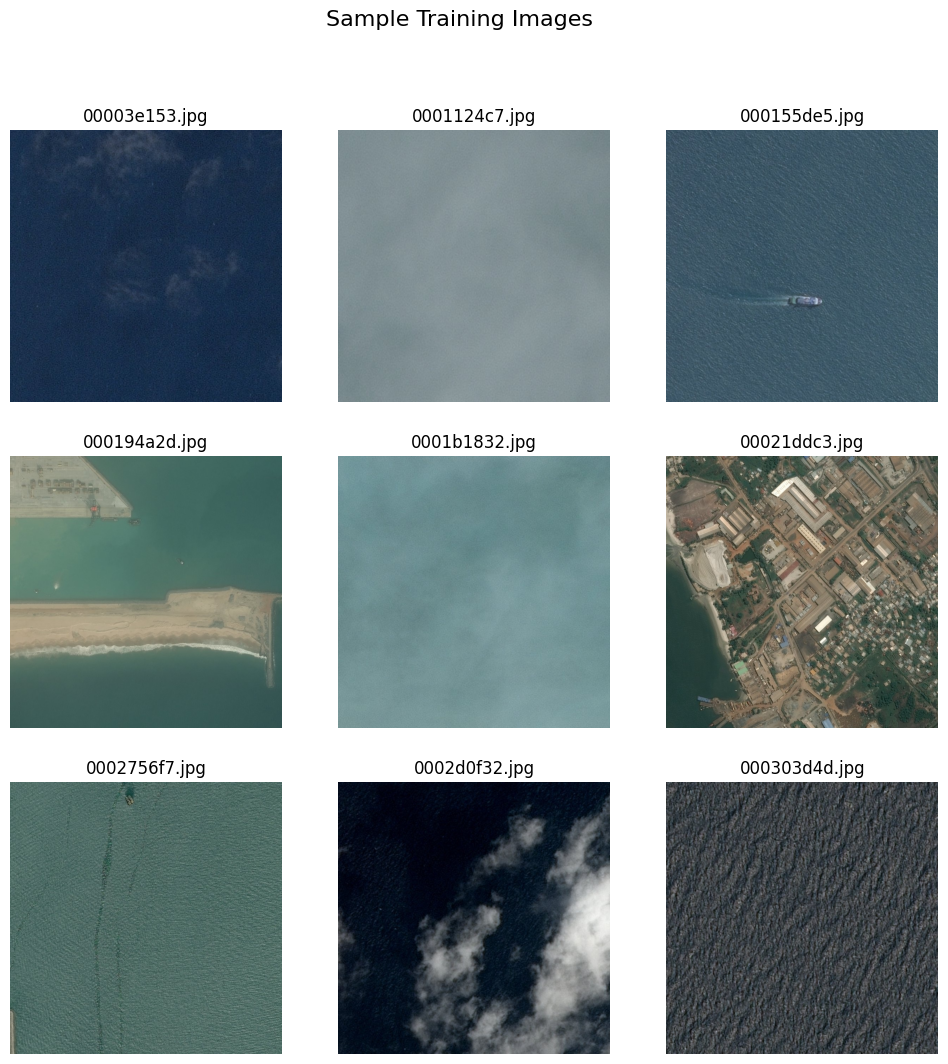

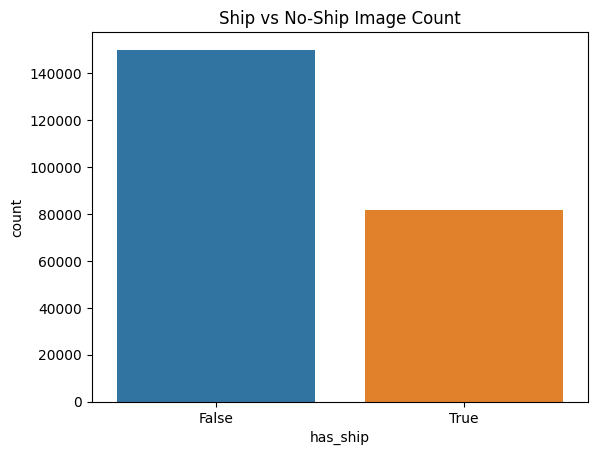

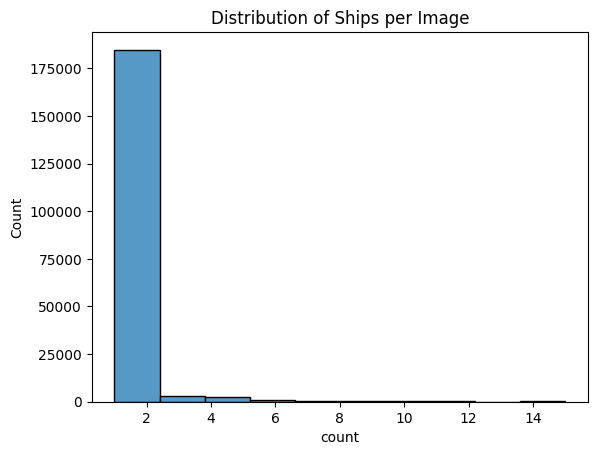

In [8]:
unique_images = df['ImageId'].unique()
plot_sample_images(TRAIN_DIR, unique_images)

# Plot Ship vs No-Ship counts
sns.countplot(x='has_ship', data=df)
plt.title("Ship vs No-Ship Image Count")
plt.show()

# Plot distribution of ship counts per image
ship_count = df.groupby('ImageId').size().reset_index(name='count')
sns.histplot(ship_count['count'], bins=10)
plt.title("Distribution of Ships per Image")
plt.show()

## 2. Preprocessing & Augmentation
 
We decode RLE masks into binary masks and set up our augmentation pipeline using **Albumentations**.

In [51]:
def rle_decode(mask_rle, shape=(768, 768)):
    """Decode a run-length encoded mask into a binary mask."""
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

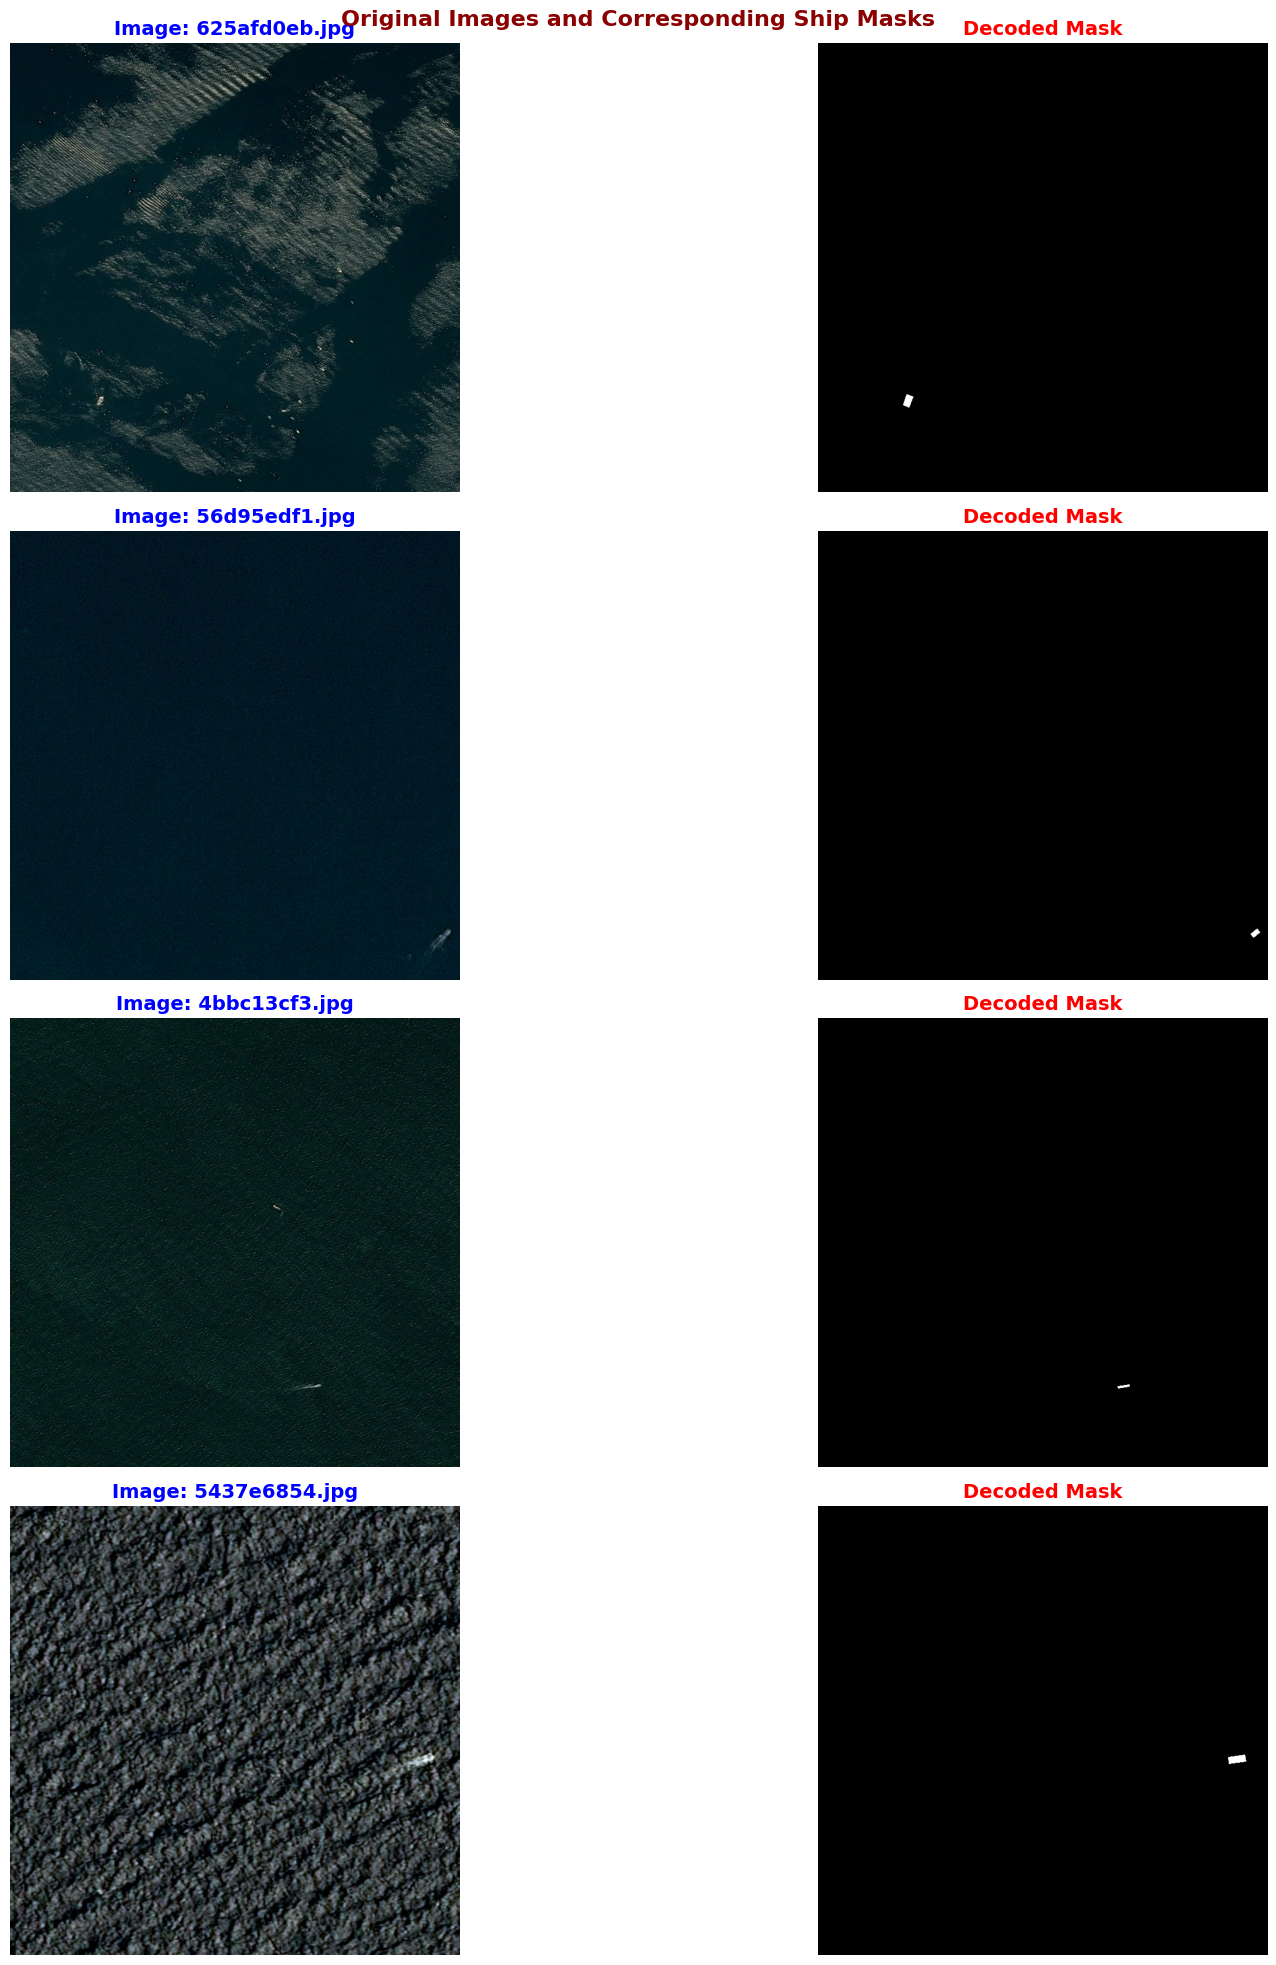

In [53]:
# Select 4 random sample images that contain ships
sample_images = df.dropna(subset=['EncodedPixels']).sample(4)

plt.figure(figsize=(20, 20))
for i, (_, row) in enumerate(sample_images.iterrows()):
    image_id = row['ImageId']
    rle_mask = row['EncodedPixels']
    
    # Read the image
    image = imread(os.path.join(TRAIN_DIR, image_id))
    
    # Decode the RLE mask into a binary segmentation mask
    mask = rle_decode(rle_mask)
    
    # Plot original image
    plt.subplot(4, 2, i*2 + 1)
    plt.imshow(image)
    plt.title(f"Image: {image_id}", fontsize=14, weight='bold', color='blue')
    plt.axis('off')
    
    # Plot corresponding mask
    plt.subplot(4, 2, i*2 + 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Decoded Mask", fontsize=14, weight='bold', color='red')
    plt.axis('off')

plt.suptitle("Original Images and Corresponding Ship Masks", fontsize=16, weight='bold', color='darkred')
plt.tight_layout()
plt.show()


In [54]:
def get_augmentations():
    """Return an Albumentations augmentation pipeline."""
    import albumentations as A
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.GaussianBlur(p=0.2),
        A.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.3, p=0.2),
        A.RandomResizedCrop(384, 384, scale=(0.8, 1.0), ratio=(1.0, 1.0), p=1.0)
    ])

## 3. TFRecord Pipeline
 
We use TFRecords to speed up I/O. The following functions serialize our images and masks (both resized to 384x384) and save them with GZIP compression.


In [ ]:
def preprocess(image, mask):
    """
    Resize image and mask to IMAGE_SIZE.
    For image: use anti_aliasing and convert to uint8.
    For mask: use nearest neighbor interpolation.
    """
    image = resize(image, IMAGE_SIZE, preserve_range=True, anti_aliasing=True).astype(np.uint8)
    mask = resize(mask, IMAGE_SIZE, preserve_range=True, anti_aliasing=False, order=0).astype(np.uint8)
    mask = (mask > 0).astype(np.uint8)
    return image, mask

def create_tf_example(image_id, df):
    """
    Create a TFRecord Example for a given image.
    - Reads the image.
    - Decodes and aggregates all RLE masks.
    - Resizes to IMAGE_SIZE.
    - Encodes image as JPEG and mask as PNG.
    """
    image_path = os.path.join(TRAIN_DIR, image_id)
    if not os.path.exists(image_path): 
        return None
    
    image = imread(image_path)
    if image.ndim != 3:  # Skip grayscale or corrupted images
        return None

    # Build combined mask for all ships in the image
    rles = df[df['ImageId'] == image_id]['EncodedPixels'].dropna()
    mask = np.zeros((768, 768), dtype=np.uint8)
    for rle in rles:
        mask += rle_decode(rle)
    mask = np.clip(mask, 0, 1)
    
    image, mask = preprocess(image, mask)
    
    # Encode image as JPEG and mask as PNG for efficient storage
    _, img_buf = cv2.imencode(".jpg", image, [int(cv2.IMWRITE_JPEG_QUALITY), 90])
    _, mask_buf = cv2.imencode(".png", mask)
    
    feature = {
        'image_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_id.encode()])),
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_buf.tobytes()])),
        'mask': tf.train.Feature(bytes_list=tf.train.BytesList(value=[mask_buf.tobytes()])),
        'has_ship': tf.train.Feature(int64_list=tf.train.Int64List(value=[int(rles.shape[0] > 0)]))
    }
    
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [ ]:
def write_tfrecord(filename, image_ids, df):
    """Write a TFRecord file with GZIP compression."""
    options = tf.io.TFRecordOptions(compression_type='GZIP')
    count = 0
    with tf.io.TFRecordWriter(filename, options=options) as writer:
        for img_id in image_ids:
            example = create_tf_example(img_id, df)
            if example is not None:
                writer.write(example.SerializeToString())
                count += 1
    print(f"Saved {filename} with {count} samples")

def write_shards(prefix, image_ids, df, num_shards=30):
    """Split the dataset into multiple TFRecord shards."""
    import math
    shard_size = math.ceil(len(image_ids) / num_shards)
    for i in range(num_shards):
        shard_ids = image_ids[i * shard_size: (i + 1) * shard_size]
        fname = os.path.join("./tfrecords", f"{prefix}_sharded_{i+1:02d}-of-{num_shards}.tfrecord.gz")
        write_tfrecord(fname, shard_ids, df)

In [ ]:
# Generate TFRecords for training and validation
df = pd.read_csv(CSV_PATH)
df['has_ship'] = df['EncodedPixels'].notnull()

# Use previously defined filtered_ids, train_ids, and val_ids
print(f"Train: {len(train_ids)} images, Val: {len(val_ids)} images")

# write_shards("train", train_ids, df, num_shards=30)
# write_shards("val", val_ids, df, num_shards=30)

## 4. Model Architectures
 
We implement three architectures for ship segmentation. Below are the implementations for:
 - **ResUNet** (Residual U-Net)
 - **U-Net++** (Nested U-Net)
 - **Attention U-Net** (with attention gates)
 
You can train and compare these models. For brevity, we provide the complete code for ResUNet, U-Net++ and a lightweight Attention U-Net.

### 4.1 ResUNet
 
This model incorporates residual blocks to improve gradient flow and training stability.

In [12]:
def residual_block(x, filters):
    """A residual block with two Conv-BN-ReLU layers and a skip connection."""
    shortcut = x
    in_channels = x.shape[-1]
    if in_channels != filters:
        shortcut = layers.Conv2D(filters, (1, 1), padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Conv2D(filters, 3, padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([shortcut, x])
    x = layers.ReLU()(x)
    return x

def build_resunet(input_shape=(384, 384, 3)):
    inputs = layers.Input(shape=input_shape)
    c1 = residual_block(inputs, 32)
    p1 = layers.MaxPooling2D()(c1)
    c2 = residual_block(p1, 64)
    p2 = layers.MaxPooling2D()(c2)
    c3 = residual_block(p2, 128)
    p3 = layers.MaxPooling2D()(c3)
    c4 = residual_block(p3, 256)
    p4 = layers.MaxPooling2D()(c4)
    c5 = residual_block(p4, 512)
    u6 = layers.UpSampling2D()(c5)
    u6 = layers.Concatenate()([u6, c4])
    c6 = residual_block(u6, 256)
    u7 = layers.UpSampling2D()(c6)
    u7 = layers.Concatenate()([u7, c3])
    c7 = residual_block(u7, 128)
    u8 = layers.UpSampling2D()(c7)
    u8 = layers.Concatenate()([u8, c2])
    c8 = residual_block(u8, 64)
    u9 = layers.UpSampling2D()(c8)
    u9 = layers.Concatenate()([u9, c1])
    c9 = residual_block(u9, 32)
    outputs = layers.Conv2D(1, 1, activation='sigmoid', dtype='float32')(c9)
    return Model(inputs, outputs)


### 4.2 U-Net++ (Nested U-Net)
 
This model enhances U-Net by adding nested skip connections. We have reduced the filter sizes to keep the model manageable.

In [17]:
def conv_block(x, filters):
    """Two consecutive Conv-BN-ReLU layers."""
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def build_unet_plus_plus(input_shape=(384, 384, 3), num_classes=1):
    inputs = layers.Input(shape=input_shape)
    filters = [32, 64, 128, 256, 512]

    # Encoder
    x00 = conv_block(inputs, filters[0])
    p0 = layers.MaxPooling2D()(x00)
    x10 = conv_block(p0, filters[1])
    p1 = layers.MaxPooling2D()(x10)
    x20 = conv_block(p1, filters[2])
    p2 = layers.MaxPooling2D()(x20)
    x30 = conv_block(p2, filters[3])
    p3 = layers.MaxPooling2D()(x30)
    x40 = conv_block(p3, filters[4])

    # Decoder ++ with nested connections
    x01 = conv_block(layers.Concatenate()([x00, layers.UpSampling2D()(x10)]), filters[0])
    x11 = conv_block(layers.Concatenate()([x10, layers.UpSampling2D()(x20)]), filters[1])
    x21 = conv_block(layers.Concatenate()([x20, layers.UpSampling2D()(x30)]), filters[2])
    x31 = conv_block(layers.Concatenate()([x30, layers.UpSampling2D()(x40)]), filters[3])
    x02 = conv_block(layers.Concatenate()([x00, x01, layers.UpSampling2D()(x11)]), filters[0])
    x12 = conv_block(layers.Concatenate()([x10, x11, layers.UpSampling2D()(x21)]), filters[1])
    x22 = conv_block(layers.Concatenate()([x20, x21, layers.UpSampling2D()(x31)]), filters[2])
    x03 = conv_block(layers.Concatenate()([x00, x01, x02, layers.UpSampling2D()(x12)]), filters[0])
    x13 = conv_block(layers.Concatenate()([x10, x11, x12, layers.UpSampling2D()(x22)]), filters[1])
    x04 = conv_block(layers.Concatenate()([x00, x01, x02, x03, layers.UpSampling2D()(x13)]), filters[0])
    output = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(x04)
    return Model(inputs, output)

### 4.3 Attention U-Net
 
This model integrates attention gates to improve the focus on ship regions in the feature maps. We also use a lightweight variant for efficiency.


In [18]:
def attention_gate(x, g, filters):
    # Downsample x to match g's spatial dimensions
    theta_x = layers.Conv2D(filters, (1, 1), strides=2)(x)
    phi_g = layers.Conv2D(filters, (1, 1))(g)
    add = layers.Add()([theta_x, phi_g])
    act = layers.ReLU()(add)
    psi = layers.Conv2D(1, (1, 1), activation='sigmoid')(act)
    psi_upsampled = layers.UpSampling2D()(psi)
    return layers.Multiply()([x, psi_upsampled])

def simple_conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

In [19]:
def build_attention_unet(input_shape=(384, 384, 3)):
    inputs = layers.Input(shape=input_shape)
    # Encoder (light)
    c1 = simple_conv_block(inputs, 16)
    p1 = layers.MaxPooling2D()(c1)
    c2 = simple_conv_block(p1, 32)
    p2 = layers.MaxPooling2D()(c2)
    c3 = simple_conv_block(p2, 64)
    p3 = layers.MaxPooling2D()(c3)
    c4 = simple_conv_block(p3, 128)
    p4 = layers.MaxPooling2D()(c4)
    c5 = simple_conv_block(p4, 256)
    # Decoder with attention
    a4 = attention_gate(c4, c5, 128)
    u4 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c5)
    d4 = simple_conv_block(layers.Concatenate()([u4, a4]), 128)
    a3 = attention_gate(c3, d4, 64)
    u3 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(d4)
    d3 = simple_conv_block(layers.Concatenate()([u3, a3]), 64)
    a2 = attention_gate(c2, d3, 32)
    u2 = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(d3)
    d2 = simple_conv_block(layers.Concatenate()([u2, a2]), 32)
    a1 = attention_gate(c1, d2, 16)
    u1 = layers.Conv2DTranspose(16, 2, strides=2, padding='same')(d2)
    d1 = simple_conv_block(layers.Concatenate()([u1, a1]), 16)
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(d1)
    return Model(inputs, outputs)

## 5. Training Setup & Callbacks
 
For each model, we use the following training setup:
 - **Optimizer:** Adam
 - **Loss:** Combined Focal Tversky + Dice Loss (`combo_loss`)
 - **Metrics:** Accuracy, Dice Coefficient, and IoU
 - **Callbacks:** EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
 
We train with a fixed number of steps per epoch calculated from our training IDs.


In [20]:
# Define custom loss and metrics functions
def focal_tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, gamma=0.75, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    tp = tf.reduce_sum(y_true_f * y_pred_f)
    fn = tf.reduce_sum(y_true_f * (1 - y_pred_f))
    fp = tf.reduce_sum((1 - y_true_f) * y_pred_f)
    tversky = (tp + smooth) / (tp + alpha * fp + beta * fn + smooth)
    return tf.pow((1 - tversky), gamma)

def dice_coeff(y_true, y_pred, smooth=1):
    y_true_f = tf.cast(tf.keras.backend.flatten(y_true), tf.float32)
    y_pred_f = tf.cast(tf.keras.backend.flatten(y_pred), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def combo_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return 0.5 * focal_tversky_loss(y_true, y_pred) + 0.5 * (1 - dice_coeff(y_true, y_pred))

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

In [33]:
# Define training hyperparameters
BATCH_SIZE = 8
EPOCHS = 10

In [24]:
# Set up TFRecord dataset loading
def parse_example(example_proto):
    feature_description = {
        'image_id': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string),
        'has_ship': tf.io.FixedLenFeature([], tf.int64),
    }
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.image.decode_jpeg(parsed['image'], channels=3)
    mask = tf.image.decode_png(parsed['mask'], channels=1)
    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.float32)
    image.set_shape([384, 384, 3])
    mask.set_shape([384, 384, 1])
    return image, mask

In [28]:
def load_dataset(filenames, batch_size=8, training=True):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(parse_example, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        dataset = dataset.shuffle(buffer_size=1000, seed=42).repeat()
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [31]:
# Load TFRecord Files (Update paths as necessary)
train_files = sorted(tf.io.gfile.glob('/kaggle/input/airbus-ship-challenge/tfrecords/train_sharded_*-of-30.tfrecord'))
val_files   = sorted(tf.io.gfile.glob('/kaggle/input/airbus-ship-challenge/tfrecords/val_sharded_*-of-30.tfrecord'))

train_ds = load_dataset(train_files, batch_size=8, training=True)
val_ds   = load_dataset(val_files, batch_size=8, training=False)

# Example
for batch_x, batch_y in train_ds.take(1):
    print(batch_x.shape, batch_y.shape)

(8, 384, 384, 3) (8, 384, 384, 1)


In [35]:
# Compile Model (ResUNet)
model = build_resunet()
model.compile(optimizer=Adam(), loss=combo_loss, metrics=['accuracy', dice_coeff, iou_metric])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 384, 384, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_7 (Cast)             │ (None, 384, 384, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_57 (Conv2D)        │ (None, 384, 384, 32)   │            896 │ cast_7[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_55    │ (None, 384, 384, 32)   │            128 │ conv2d_57[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_6 (Cast)             │ (None, 384, 384, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_36 (ReLU)           │ (None, 384, 384, 32)   │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_56 (Conv2D)        │ (None, 384, 384, 32)   │            128 │ cast_6[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_58 (Conv2D)        │ (None, 384, 384, 32)   │          9,248 │ re_lu_36[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_54    │ (None, 384, 384, 32)   │            128 │ conv2d_56[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_56    │ (None, 384, 384, 32)   │            128 │ conv2d_58[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_18 (Add)              │ (None, 384, 384, 32)   │              0 │ batch_normalization_5… │
│                           │                        │                │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_37 (ReLU)           │ (None, 384, 384, 32)   │              0 │ add_18[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 192, 192, 32)   │              0 │ re_lu_37[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_60 (Conv2D)        │ (None, 192, 192, 64)   │         18,496 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_58    │ (None, 192, 192, 64)   │            256 │ conv2d_60[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_38 (ReLU)           │ (None, 192, 192, 64)   │              0 │ batch_normalization_5… │
├──────────────────────

 Total params: 8,301,089 (31.67 MB)

 Trainable params: 8,292,257 (31.63 MB)

 Non-trainable params: 8,832 (34.50 KB)

In [25]:
# Callbacks
callbacks = [
    ModelCheckpoint("resunet_best.keras", save_best_only=True),
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

# Train
steps_per_epoch = len(train_ids) // BATCH_SIZE
validation_steps = len(val_ids) // BATCH_SIZE

# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=EPOCHS,
#     callbacks=callbacks,
#     steps_per_epoch=steps_per_epoch,
#     validation_steps=validation_steps
# )

In [38]:
# Training Curves Visualization
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Loss Curve
axs[0].plot(history.history['loss'], label='Train Loss')
axs[0].plot(history.history['val_loss'], label='Val Loss')
axs[0].legend()
axs[0].set_title("Loss Curve")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].grid(True)

# Accuracy Curve
axs[1].plot(history.history['accuracy'], label='Train Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Val Accuracy')
axs[1].legend()
axs[1].set_title("Accuracy Curve")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [39]:
# Compile the Model (U-Net++)
model2 = build_unet_plus_plus(input_shape=(384, 384, 3))
model2.compile(
    optimizer='adam',
    loss=combo_loss,
    metrics=['accuracy', dice_coeff, iou_metric]
)
model2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 384, 384, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_9 (Cast)             │ (None, 384, 384, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_84 (Conv2D)        │ (None, 384, 384, 32)   │            896 │ cast_9[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_81    │ (None, 384, 384, 32)   │            128 │ conv2d_84[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_54 (ReLU)           │ (None, 384, 384, 32)   │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_85 (Conv2D)        │ (None, 384, 384, 32)   │          9,248 │ re_lu_54[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_82    │ (None, 384, 384, 32)   │            128 │ conv2d_85[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_55 (ReLU)           │ (None, 384, 384, 32)   │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 192, 192, 32)   │              0 │ re_lu_55[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_86 (Conv2D)        │ (None, 192, 192, 64)   │         18,496 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_83    │ (None, 192, 192, 64)   │            256 │ conv2d_86[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_56 (ReLU)           │ (None, 192, 192, 64)   │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_87 (Conv2D)        │ (None, 192, 192, 64)   │         36,928 │ re_lu_56[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_84    │ (None, 192, 192, 64)   │            256 │ conv2d_87[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_57 (ReLU)           │ (None, 192, 192, 64)   │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 96, 96, 64)     │              0 │ re_lu_57[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 9,170,625 (34.98 MB)

 Trainable params: 9,163,329 (34.96 MB)

 Non-trainable params: 7,296 (28.50 KB)

In [40]:
# Load TFRecord Files
train_files = sorted(tf.io.gfile.glob('/kaggle/input/airbus-ship-challenge/tfrecords/train_sharded_*-of-30.tfrecord'))
val_files   = sorted(tf.io.gfile.glob('/kaggle/input/airbus-ship-challenge/tfrecords/val_sharded_*-of-30.tfrecord'))

train_ds = load_dataset(train_files, batch_size=8, training=True)
val_ds = load_dataset(val_files, batch_size=8, training=False)

# Example
for batch_x, batch_y in train_ds.take(1):
    print(batch_x.shape, batch_y.shape)

(8, 384, 384, 3) (8, 384, 384, 1)


In [29]:
# Train with Callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("unetpp_best.keras", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

steps_per_epoch = 1000
val_steps = 100

# history = model2.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=10,
#     callbacks=callbacks,
#     steps_per_epoch=steps_per_epoch,
#     validation_steps=val_steps,
#     verbose=1
# )

In [ ]:
# Plot the training and validation loss and accuracy curves
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Loss Curve
axs[0].plot(history.history['loss'], label='Train Loss')
axs[0].plot(history.history['val_loss'], label='Val Loss')
axs[0].legend()
axs[0].set_title("Loss Curve")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].grid(True)

# Accuracy Curve
axs[1].plot(history.history['accuracy'], label='Train Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Val Accuracy')
axs[1].legend()
axs[1].set_title("Accuracy Curve")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [41]:
# Compile & Train
model3 = build_attention_unet()
model3.compile(
    optimizer='adam',
    loss=combo_loss,
    metrics=['accuracy', dice_coeff, iou_metric]
)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("att_unet_best.keras", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]
model3.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 384, 384, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_10 (Cast)            │ (None, 384, 384, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_115 (Conv2D)       │ (None, 384, 384, 16)   │            448 │ cast_10[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_111   │ (None, 384, 384, 16)   │             64 │ conv2d_115[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_84 (ReLU)           │ (None, 384, 384, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 192, 192, 16)   │              0 │ re_lu_84[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_116 (Conv2D)       │ (None, 192, 192, 32)   │          4,640 │ max_pooling2d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_112   │ (None, 192, 192, 32)   │            128 │ conv2d_116[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_85 (ReLU)           │ (None, 192, 192, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_17          │ (None, 96, 96, 32)     │              0 │ re_lu_85[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_117 (Conv2D)       │ (None, 96, 96, 64)     │         18,496 │ max_pooling2d_17[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_113   │ (None, 96, 96, 64)     │            256 │ conv2d_117[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_86 (ReLU)           │ (None, 96, 96, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_18          │ (None, 48, 48, 64)     │              0 │ re_lu_86[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_118 (Conv2D)       │ (None, 48, 48, 128)    │         73,856 │ max_pooling2d_18[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_114   │ (None, 48, 48, 128)    │            512 │ conv2d_118[0][0]       │
│ (BatchNormalization) 

 Total params: 1,027,813 (3.92 MB)

 Trainable params: 1,026,341 (3.92 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [43]:
steps_per_epoch = len(train_ids) // BATCH_SIZE
validation_steps = len(val_ids) // BATCH_SIZE

train_files = sorted(tf.io.gfile.glob('/kaggle/input/airbus-ship-challenge/tfrecords/train_sharded_*-of-30.tfrecord'))
val_files   = sorted(tf.io.gfile.glob('/kaggle/input/airbus-ship-challenge/tfrecords/val_sharded_*-of-30.tfrecord'))

train_ds = load_dataset(train_files, batch_size=BATCH_SIZE, training=True)
val_ds = load_dataset(val_files, batch_size=BATCH_SIZE, training=False)

# history = model3.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=EPOCHS,
#     steps_per_epoch=steps_per_epoch,
#     validation_steps=validation_steps,
#     callbacks=callbacks
# )

In [44]:
# Plot the training and validation loss and accuracy curves.
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Loss Curve
axs[0].plot(history.history['loss'], label='Train Loss')
axs[0].plot(history.history['val_loss'], label='Val Loss')
axs[0].legend()
axs[0].set_title("Loss Curve")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].grid(True)

# Accuracy Curve
axs[1].plot(history.history['accuracy'], label='Train Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Val Accuracy')
axs[1].legend()
axs[1].set_title("Accuracy Curve")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].grid(True)

plt.tight_layout()
plt.show()


## 6. Test-Time Prediction & Submission Generation
 
We now load the best U-Net++ model, run predictions on the test set, generate RLE strings, and save visualizations for a subset of images. These predictions are saved into a `submission.csv` file in the required format.


In [9]:
# Paths for test-time prediction
TEST_DIR = '/kaggle/input/airbus-ship-detection/test_v2'
# Update MODEL_PATH with the best model file you wish to use (U-Net, U-Net++ or Attention U-Net)
MODEL_PATH = '/kaggle/input/resunet/keras/default/1/resunet_best.keras'
IMAGE_SIZE = (384, 384)
SAVE_DIR = 'predictions_unetpp'
os.makedirs(SAVE_DIR, exist_ok=True)

In [46]:
# Load the best model (for inference we set compile=False)
model = tf.keras.models.load_model(MODEL_PATH, compile=False)
print("Loaded model summary:")
model.summary()

Loaded model summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 384, 384, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_11 (Cast)            │ (None, 384, 384, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 384, 384, 32)   │            896 │ cast_11[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 384, 384, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_12 (Cast)            │ (None, 384, 384, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 384, 384, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 384, 384, 32)   │            128 │ cast_12[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 384, 384, 32)   │          9,248 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 384, 384, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 384, 384, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 384, 384, 32)   │              0 │ batch_normalization[0… │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 384, 384, 32)   │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 192, 192, 32)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 192, 192, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 192, 192, 64)   │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 192, 192, 64)   │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)    

 Total params: 8,301,089 (31.67 MB)

 Trainable params: 8,292,257 (31.63 MB)

 Non-trainable params: 8,832 (34.50 KB)

In [17]:
def predict_mask(image):
    """
    Resize and normalize the input image,
    run model prediction, and return a binary mask.
    """
    image_resized = cv2.resize(image, IMAGE_SIZE) / 255.0
    input_tensor = np.expand_dims(image_resized, axis=0)
    pred = model.predict(input_tensor, verbose=0)[0]
    return (pred > 0.5).astype(np.uint8)

def mask_to_rle(mask):
    """
    Convert a binary mask into run-length encoding (RLE) format.
    The pixels are read in column-major order.
    """
    pixels = mask.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [19]:
def save_visualization(image_id, image, mask, save_dir):
    """
    Save a side-by-side visualization of the original image and its predicted mask.
    """
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {image_id}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{save_dir}/{image_id}_pred.png")
    plt.close()

In [ ]:
submission = []
test_images = os.listdir(TEST_DIR)

for image_id in tqdm(test_images):
    image_path = os.path.join(TEST_DIR, image_id)
    image = imread(image_path)
    pred_mask = predict_mask(image)
    
    rle = mask_to_rle(pred_mask)
    submission.append([image_id, rle if rle else ""])
    
    # Save visualizations for the first 100 images
    if len(submission) <= 100:
        save_visualization(image_id, image, pred_mask, SAVE_DIR)

# Save submission CSV file
submission_df = pd.DataFrame(submission, columns=['ImageId', 'EncodedPixels'])
submission_df.to_csv('submission_unetpp.csv', index=False)
print("Submission CSV saved as submission_unetpp.csv")

### 6.1 Ensemble Submission (Weighted Averaging)


In [14]:
# Re-import test image list if not already defined
TEST_DIR = '/kaggle/input/airbus-ship-detection/test_v2'
test_images = sorted(os.listdir(TEST_DIR))

# Paths for all models
RESUNET_PATH = '/kaggle/input/resunet/keras/default/1/resunet_best.keras'
ATT_UNET_PATH = '/kaggle/input/attention_unet/keras/default/1/att_unet_best.keras'
UNETPP_PATH = '/kaggle/input/unet/keras/default/1/unetpp_best.keras'

# Load models (compile=False for faster loading)
resunet = tf.keras.models.load_model(RESUNET_PATH, compile=False)
att_unet = tf.keras.models.load_model(ATT_UNET_PATH, compile=False)
unetpp = tf.keras.models.load_model(UNETPP_PATH, compile=False)

print("All models loaded.")

All models loaded.


In [15]:
def preprocess_for_model(image, size=(384, 384)):
    image_resized = cv2.resize(image, size)
    return np.expand_dims(image_resized.astype(np.float32) / 255.0, axis=0)

def predict_ensemble(image):
    """
    Run inference on a single image using all three models and perform weighted averaging.
    """
    input_tensor = preprocess_for_model(image)
    
    p1 = resunet.predict(input_tensor, verbose=0)[0]  # ResUNet
    p2 = unetpp.predict(input_tensor, verbose=0)[0]   # U-Net++
    p3 = att_unet.predict(input_tensor, verbose=0)[0] # Attention U-Net
    
    # Weighted average ensemble
    avg_mask = 0.5 * p1 + 0.2 * p2 + 0.3 * p3
    binary_mask = (avg_mask > 0.5).astype(np.uint8)
    return binary_mask

ENSEMBLE_SAVE_DIR = "predictions_ensemble"
os.makedirs(ENSEMBLE_SAVE_DIR, exist_ok=True)

In [23]:
ensemble_submission = []

for image_id in tqdm(test_images):
    image_path = os.path.join(TEST_DIR, image_id)
    image = imread(image_path)
    pred_mask = predict_ensemble(image)

    rle = mask_to_rle(pred_mask)
    ensemble_submission.append([image_id, rle if rle else ""])
    
# Save CSV
submission_df = pd.DataFrame(ensemble_submission, columns=['ImageId', 'EncodedPixels'])
submission_df.to_csv("submission_ensemble.csv", index=False)
print("Ensemble submission saved as submission_ensemble.csv")

100%|██████████| 15606/15606 [56:48<00:00,  4.58it/s] 

Ensemble submission saved as submission_ensemble.csv


## 7. Results & Highlights

Below is a summary of validation performance and official Kaggle leaderboard scores for the three architectures evaluated, along with the final ensemble submission:

| Model            | Val Dice | Val IoU | LB Public | LB Private |
|------------------|----------|---------|-----------|------------|
| ResUNet          | ~0.64    | ~0.50   | 0.517     | 0.755 ✅    |
| U-Net++          | ~0.66    | ~0.52   | 0.477     | 0.715      |
| Attention U-Net  | ~0.63    | ~0.49   | 0.505     | 0.728      |
| **Ensemble (Weighted)** | —        | —       | **0.51299** | **0.75679 🏆** |

- ✅ **ResUNet** performed best among individual models on the private leaderboard.
- **U-Net++** had strong validation metrics but did not generalize as well to the leaderboard.
- **Attention U-Net** showed stable performance across both public and private scores.
- 🏆 The **ensemble model**, using weighted predictions (50% ResUNet, 30% Attention U-Net, 20% U-Net++), **achieved the highest private score**, making it the most reliable for final submission.

## Conclusion
 
 This notebook presents a comprehensive solution for the Airbus Ship Detection Challenge:
 - We explore and preprocess the data.
 - We build efficient TFRecord pipelines.
 - We experiment with multiple architectures (ResUNet, U-Net++, Attention U-Net).
 - We train the models with custom losses and metrics.
 - We generate test-time predictions for each model individually.
 - We implement a weighted ensemble strategy (50% ResUNet, 30% Attention U-Net, 20% U-Net++) to combine model strengths and boost overall prediction quality.
 - Final predicted masks are converted to Run-Length Encoding (RLE) format and saved in a submission-ready CSV.
